![Fraud](./img/Fraud.png)
# Employment Scam Aegean Dataset
## 0. Imports and global settings

In [1]:
import scripts.plots as plots
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, RegexpTokenizer, word_tokenize
import pandas as pd
import re
import seaborn as sns
import string
import warnings
from wordcloud import WordCloud

sns.set(palette='RdYlGn', context='talk', rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [2]:
df = pd.read_csv("./data/fake_job_postings.csv", index_col='job_id')
df.columns = df.columns.str.title()

In [3]:
dflegit = df[df['Fraudulent']==0]
dffraud = df[df['Fraudulent']==1]

In [4]:
df.sample(n=20)

Title  \
job_id                                                      
4742                   Sr. Application Support Specialist   
3554                                   Marketing Director   
9709                          Technical Support Associate   
8036                      Operations & Partners Associate   
4746                                           Front Desk   
3316                             Producer, Khmer Service    
3919                              Social Pre-Sale Manager   
5737     Jr. Business Analyst & Quality Analyst (entry...   
5820                                 Game Studio Manager    
9225    Social Media & Community Management Rockstar I...   
13060                       Product Manager ( 2 Openings)   
11232                                     Game Programmer   
13484                                 Social Media Intern   
5624                     Marketing Assistant - Internship   
8571                   HERSHEY- Manager, Pricing Strategy   
1572                                     Sr. Web Engineer   
11634                               Application Developer   
11177                             English Teacher Abroad    
14637                    Senior Sales Executive - Central   
2198                                     Library Director   

                     Location         Department Salary_Range  \
job_id                                                          
4742      US, MN, Minneapolis                NaN          NaN   
3554         US, NY, Brooklyn                NaN          NaN   
9709          US, GA, Atlanta  Technical Support  25000-30000   
8036          GB, LND, London                NaN          NaN   
4746          US, FL, Tamarac                NaN          NaN   
3316       US, DC, Washington                NaN          NaN   
3919          GB, LND, London         Commercial          NaN   
5737       US, NJ, PISCATAWAY                NaN          NaN   
5820                   HK, ,                 NaN          NaN   
9225             GB, , London  Moni Technologies          NaN   
13060      US, CA, Santa Ana                 NaN          NaN   
11232      US, TX, Richardson                NaN          NaN   
13484            DE, , Berlin                NaN          NaN   
5624            GR, I, Athens          Marketing          NaN   
8571                   US, ,                 NaN          NaN   
1572        CA, BC, Vancouver                R&D          NaN   
11634       US, OH, Cleveland                NaN          NaN   
11177          US, MA, Boston                NaN          NaN   
14637   US, CA, San Francisco              Sales          NaN   
2198          US, WI, Delavan                NaN  55000-65000   

                                          Company_Profile  \
job_id                                                      
4742    Insite Software is looking for smart and motiv...   
3554    Maker’s Row is an online marketplace that conn...   
9709    AboutPPD Partners provides English and Spanish...   
8036    Startup Institute is the #1 career accelerator...   
4746    Senior Nannies Home Care Services was founded ...   
3316    Applied Memetics LLC is a professional service...   
3919    Ybrant Digital is the new-age digital media co...   
5737                                                  NaN   
5820    At Hayes-Corp, we create the fun stuff.  With ...   
9225    Playfair Capital is an early stage technology ...   
13060   PROSULTING IS PEOPLE The ProSulting difference...   
11232                                                 NaN   
13484   We are on a mission: Making cities smarter.Cit...   
5624    Hi, we are dopios“We are here to make any loca...   
8571    Pricing Recruiters is the leading global resou...   
1572    Pandoo TEK’s mission is to turn innovative ide...   
11634   We Provide Full Time Permanent Positions for m...   
11177   We help teachers get safe &amp; secure jobs ab...   
14637   From the lands of Can Do, Roll Our Sleeves Up ... 

# 1. Missing values
First, let us have a look at the data and see if there are any missing values.

In [5]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

Legit_HasValue  Legit_IsNA  Fraud_HasValue  Fraud_IsNA
Columns                                                                    
Title                         100.0         0.0           100.0         0.0
Location                       98.1         1.9            97.8         2.2
Department                     35.3        64.7            38.7        61.3
Salary_Range                   15.5        84.5            25.8        74.2
Company_Profile                84.0        16.0            32.2        67.8
Description                   100.0         0.0            99.9         0.1
Requirements                   85.1        14.9            82.2        17.8
Benefits                       59.8        40.2            58.0        42.0
Telecommuting                 100.0         0.0           100.0         0.0
Has_Company_Logo              100.0         0.0           100.0         0.0
Has_Questions                 100.0         0.0           100.0         0.0
Employment_Type                81.0        19.0            72.2        27.8
Required_Experience            61.1        38.9            49.8        50.2
Required_Education             55.0        45.0            47.9        52.1
Industry                       72.8        27.2            68.2        31.8
Function                       64.0        36.0            61.1        38.9
Fraudulent                    100.0         0.0           100.0         0.0

17014


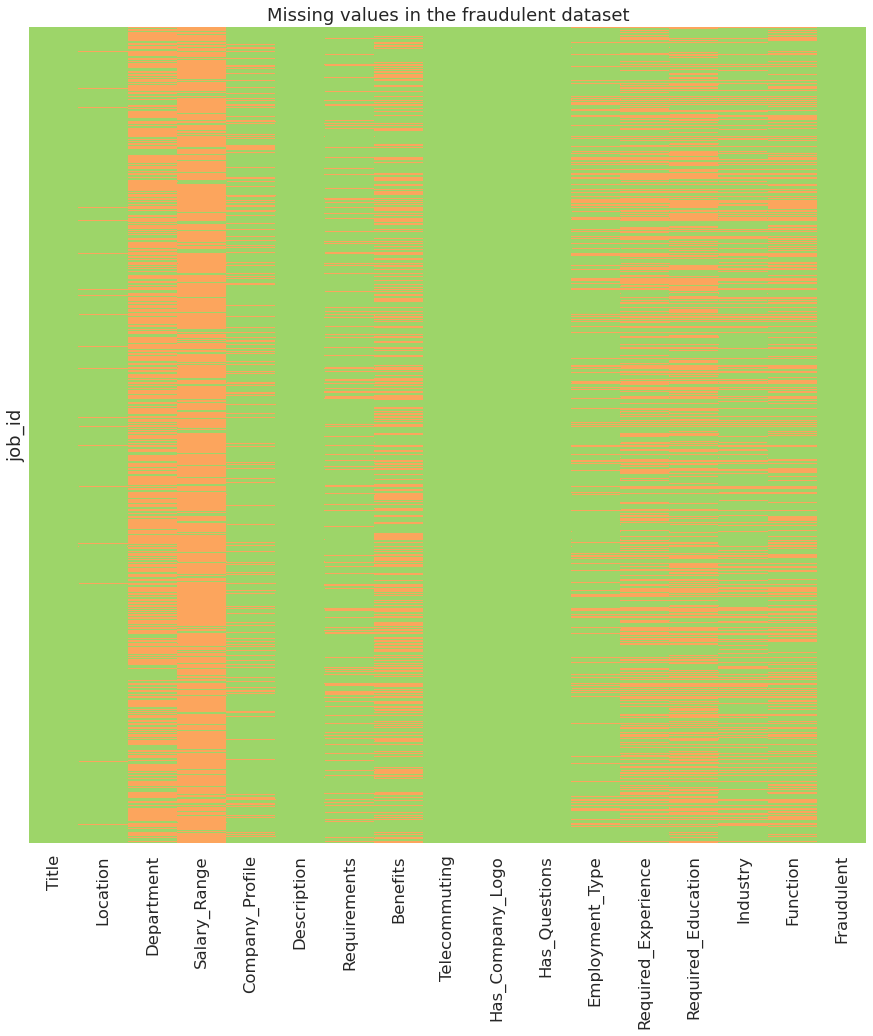

In [6]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


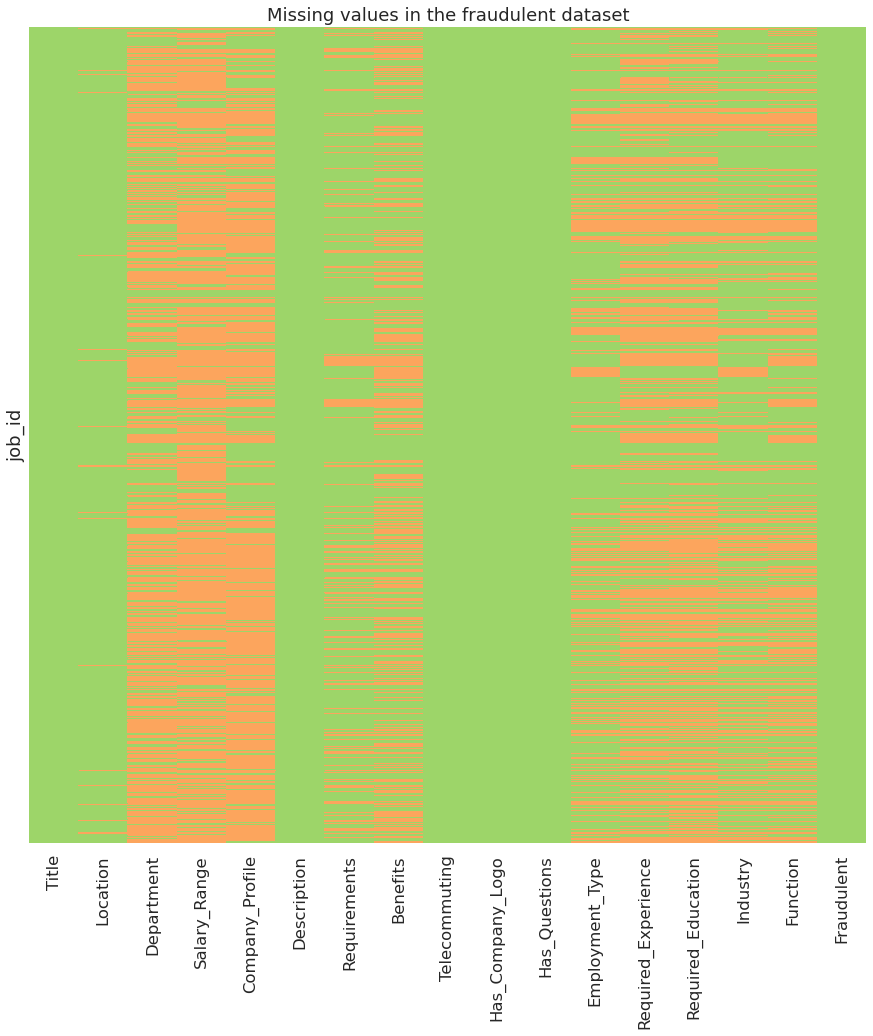

In [7]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

## 1.1 Preliminary Insights
This dataset contains 17880 jobs with a maximum of 16 characteristics given to each job. On top of this information, all jobs entry were assigned manually a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers flagged as genuine whilst 866 identified as fraudulent.

_Note: The assignment was performed manually. Errors might have occurred._

The following variables characterise each job:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

There tend to be some repetitions in some fields; `company_profile` is an obvious one but, `description` can be very similar in some cases. These repetitions might affect tf-idf scores and might require a more in-depth analysis.

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes to the company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a position as an Office Manager in Warsaw, PL.

# 2. Text fields
From the missing value visualisation, we can see the fraudsters are struggling with the company profiles, etc. Let's look at text fields, in general, to see how creative the fraudsters are.
## 2.1 Trimming the text
There is some textual artefact that need to be removed in order to have a more efficient word analysis.

In the following code,
- The first line will put a space before every capital letter (to avoid a wo.Rd scenario).
- The second line will remove the anonymised contact information.
- The third line will remove non-word characters, including digits.
- The fourth line will remove words shorter than three characters.
- The fifth line will convert multiple spaces into one space only.

In [8]:
for column in df.columns[4:8]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

## 2.2 Word Count
Next step is to look at how long posts are. More specifically, we will look at any difference between fraudulent posts and genuine ones.

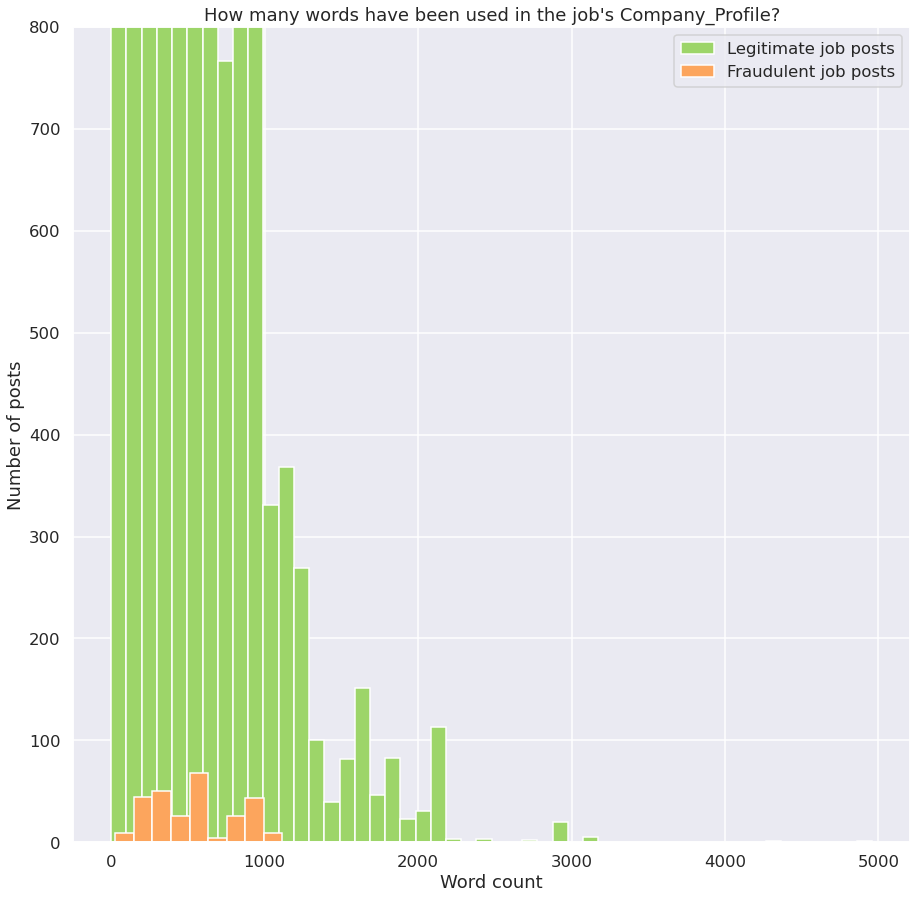

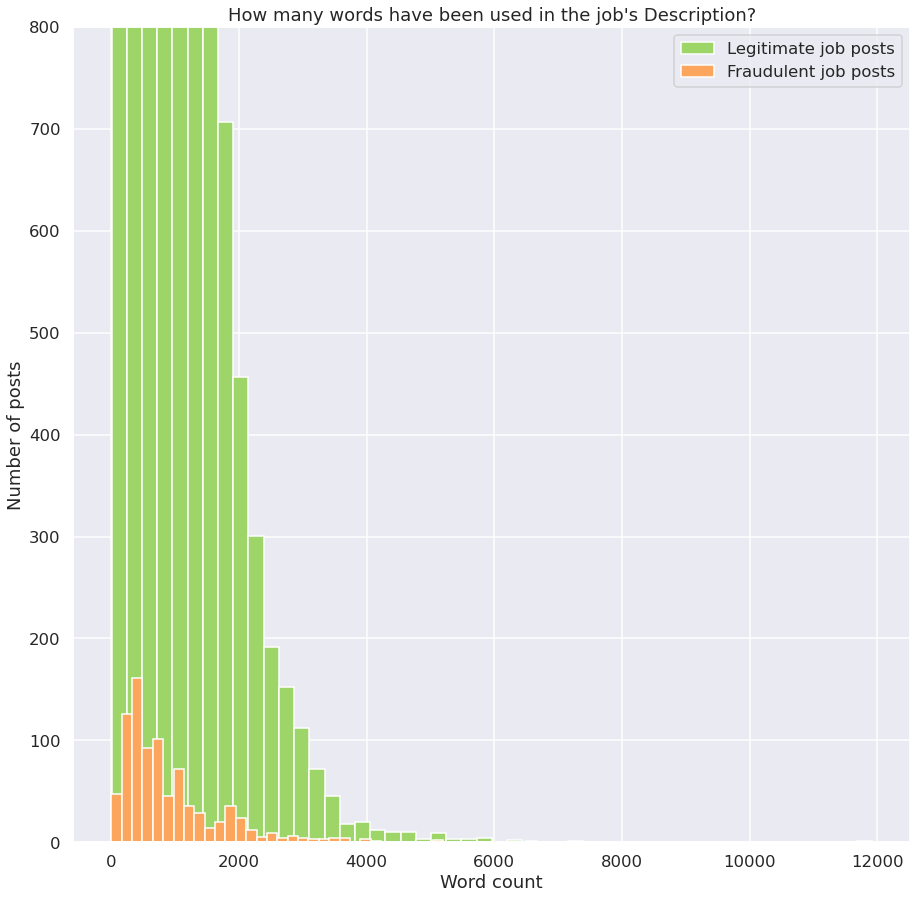

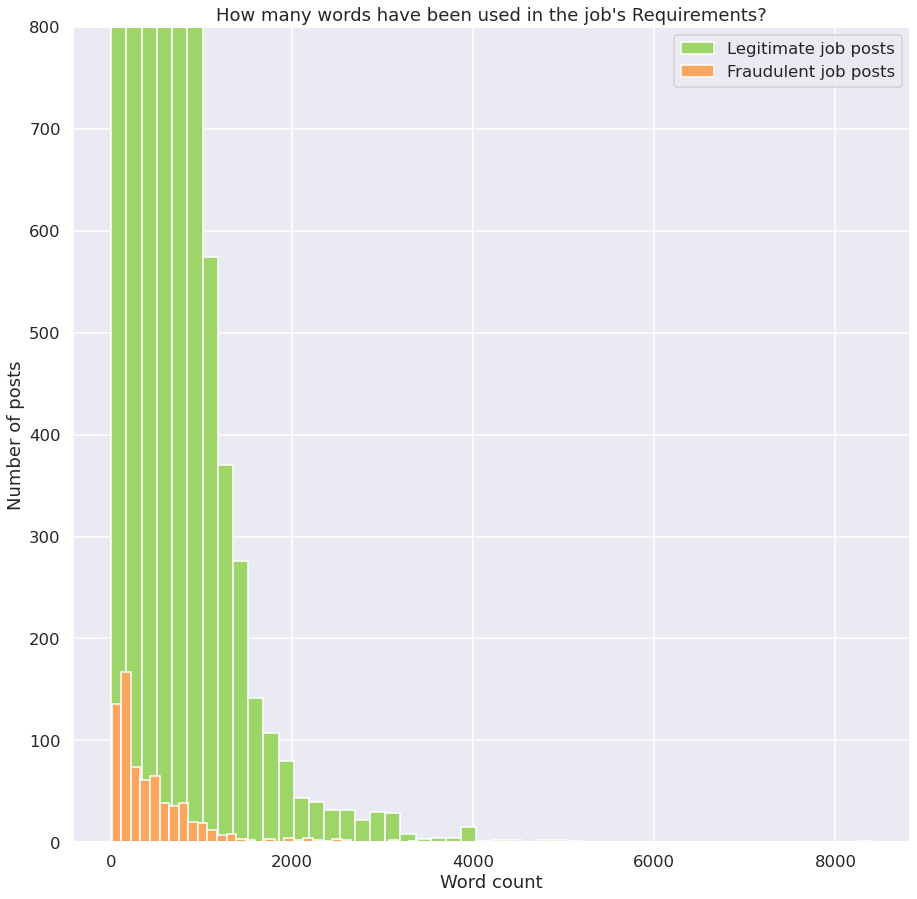

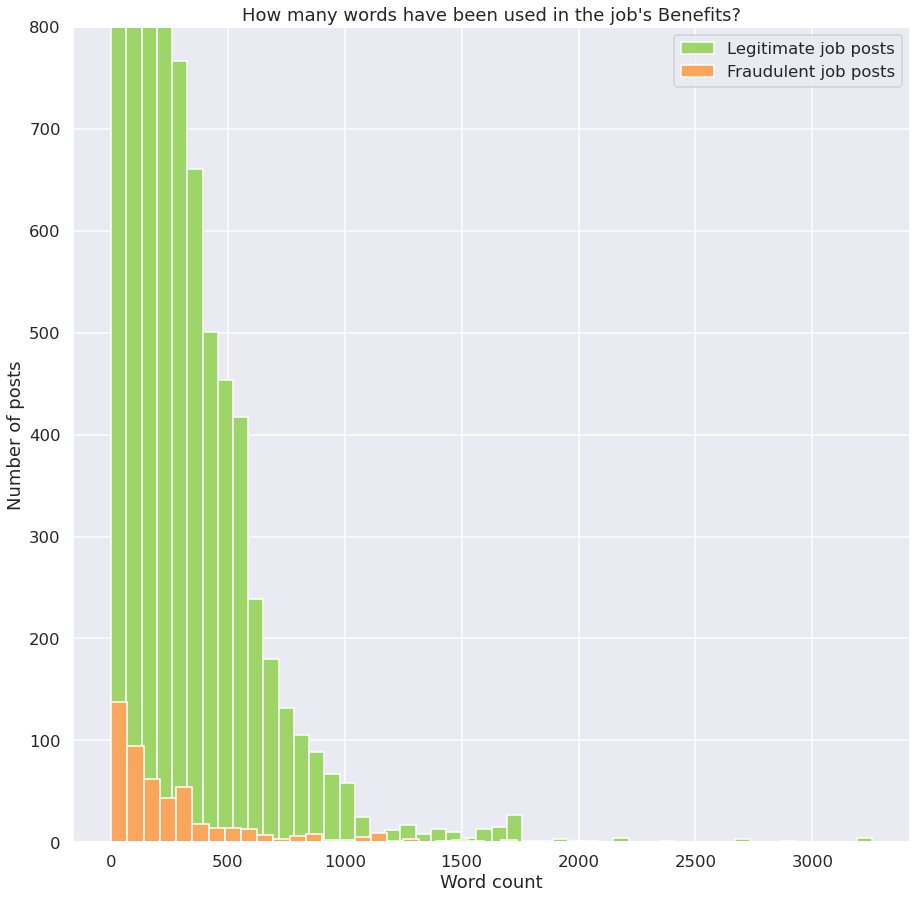

In [9]:
plots.Plots.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but, even when there is information, the fraudulent job posts are less loquacious than genuine job posts. This is especially true for the job requirements and the company profile.

Let us have a more detailed look at the content itself.
## 2.3 Vocabulary Analysis
### 2.3.1 Company Profile

In [10]:
# Removing stopwords
stop_words = list(string.punctuation)
stop_words += stopwords.words('english')
stop_words += [i for i in 'qwertyuioplkjhgfdsazxcvbnm0']

In [11]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [12]:
len(tokens_cp)

945056

In [13]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [14]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 2877
count of words: 44


#### 2.3.1.1 Company Profiles of Fraudulent Posts

In [15]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [16]:
len(tokens_cp)

18184

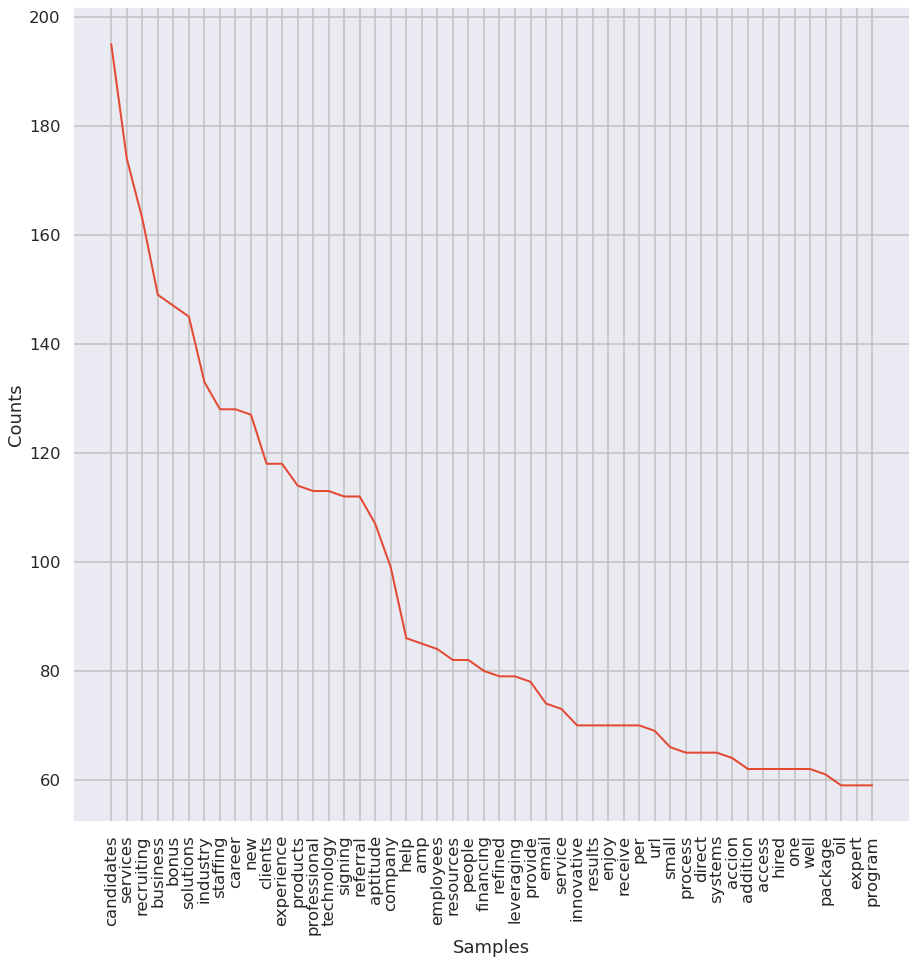

In [17]:
FreqDist(tokens_cp).plot(50)
plt.show()

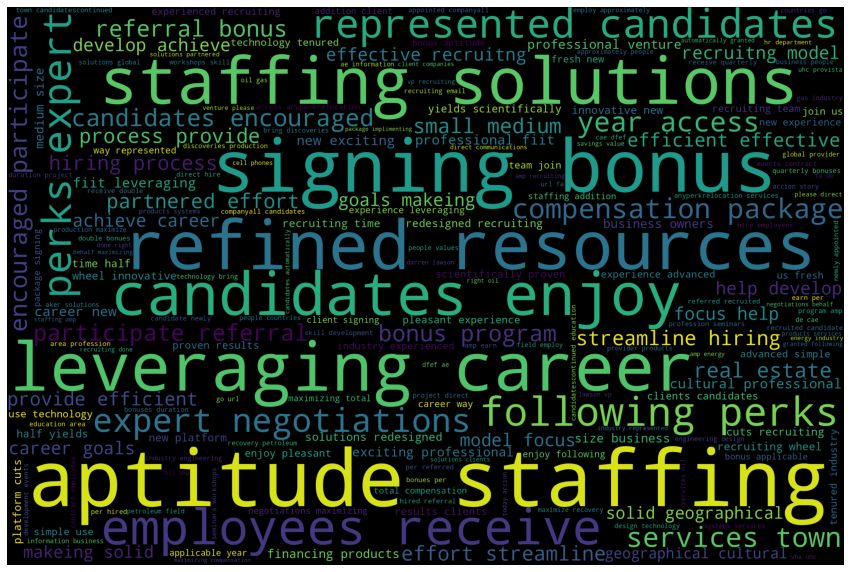

In [18]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.1.2 Company Profile of Legitimate Posts

In [19]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [20]:
len(tokens_cp)

1016833

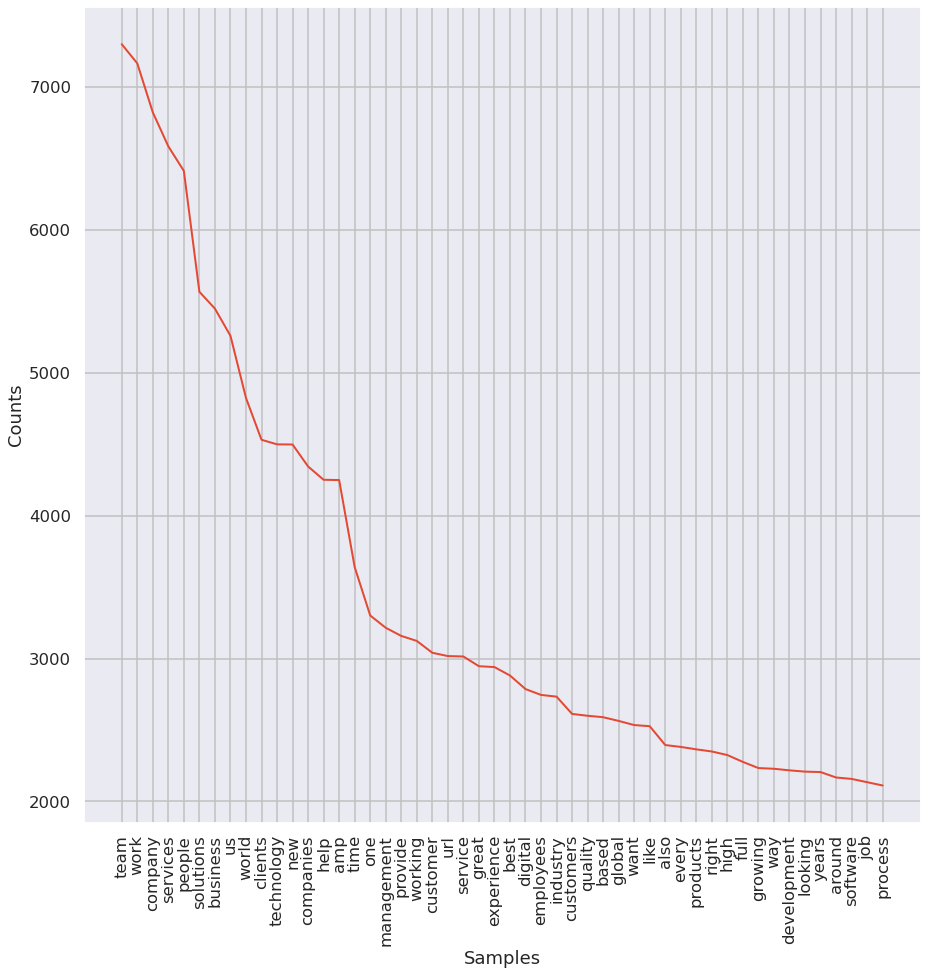

In [21]:
FreqDist(tokens_cp).plot(50)
plt.show()

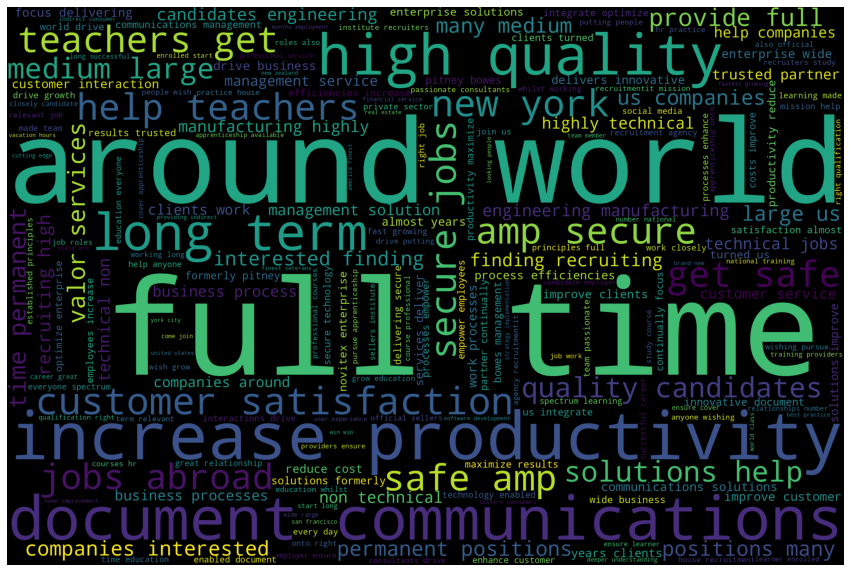

In [22]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looking at the content of fraudulent ads, it appears, the company profile would be more individual focussed, with terms like candidates, recruiting, bonus, staffing, career, signing, referral, etc.

A legitimate company seem to be more mission focussed with terms like team, people, solutions, help, business, etc.

### 2.3.2 Description

In [23]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [24]:
len(tokens_cp)

1880099

In [25]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [26]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 3391
count of words: 64


#### 2.3.2.1 Description of Fraudulent Posts

In [27]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [28]:
len(tokens_cp)

94401

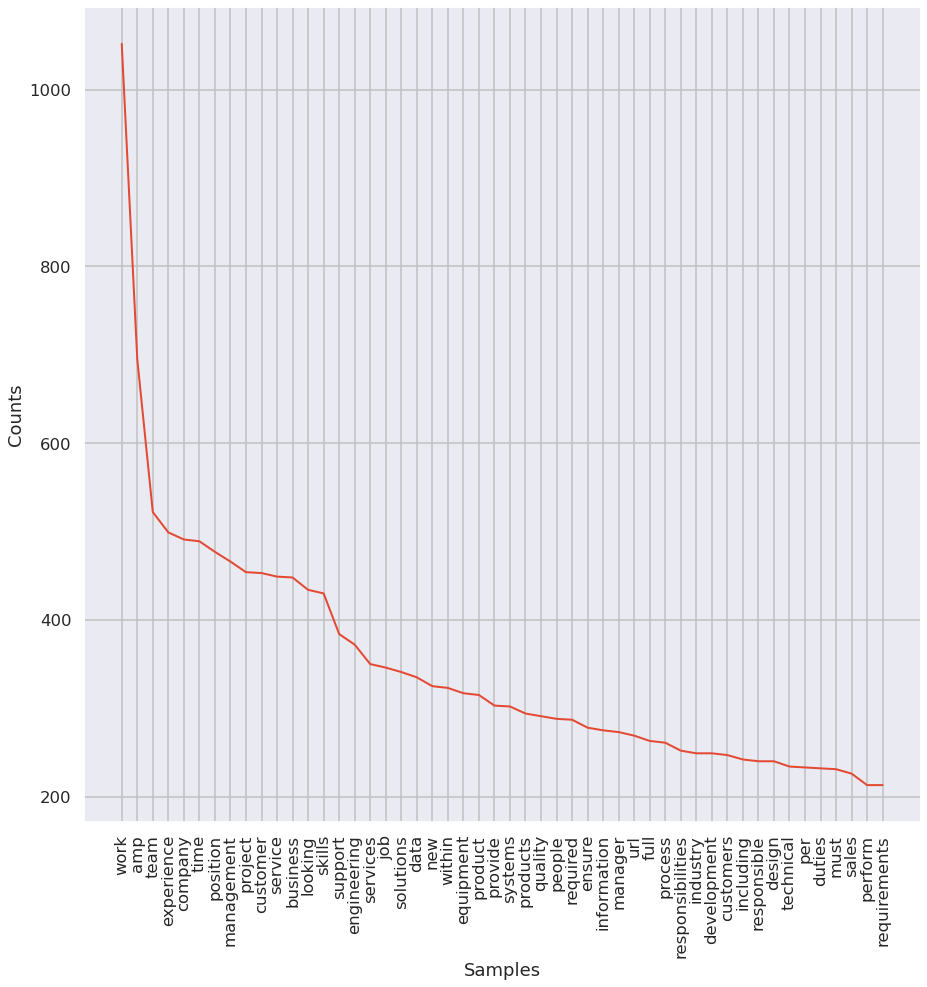

In [29]:
FreqDist(tokens_cp).plot(50)
plt.show()

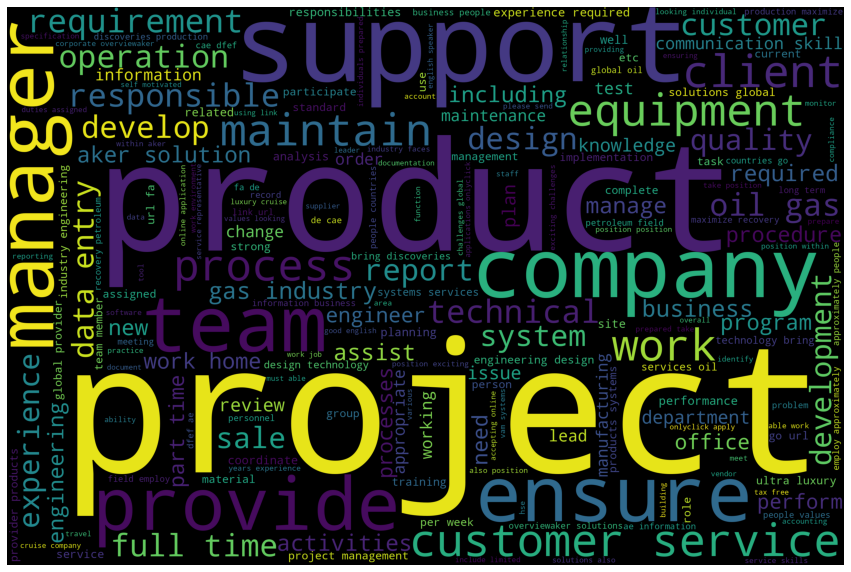

In [30]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.2.2 Description of Legitimate Posts

In [31]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [32]:
len(tokens_cp)

1911962

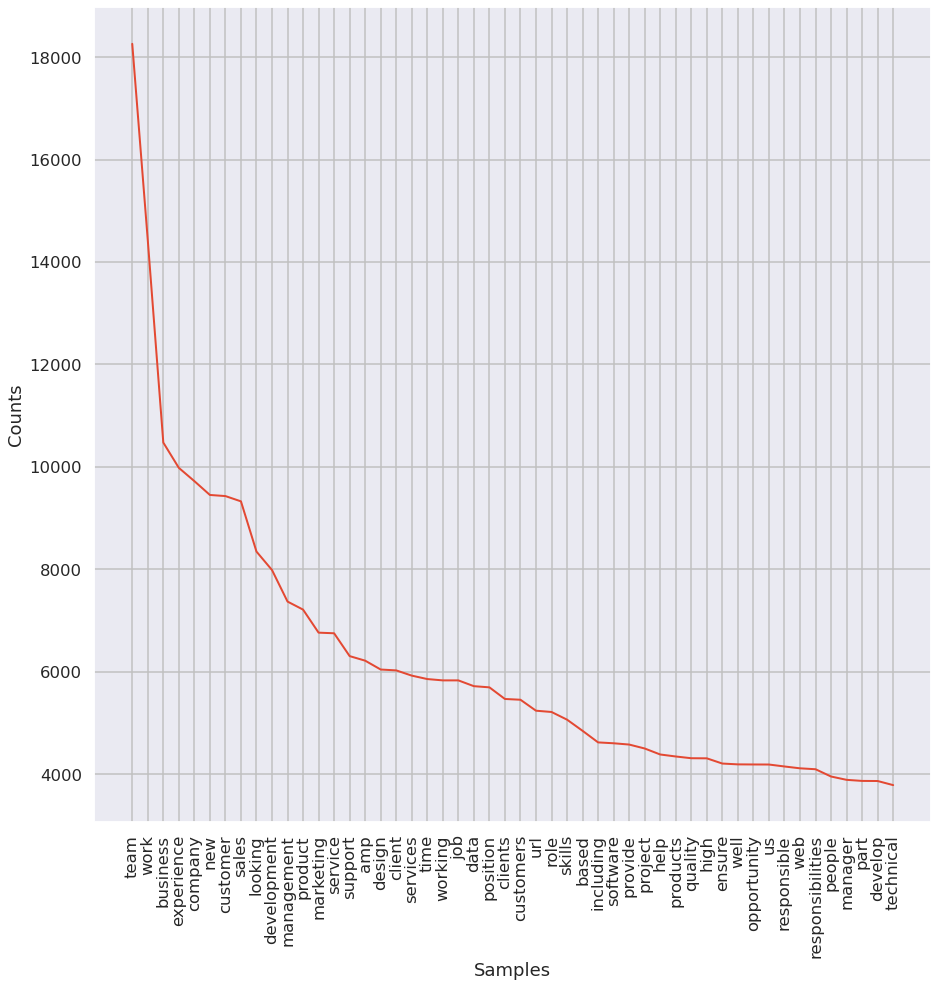

In [33]:
FreqDist(tokens_cp).plot(50)
plt.show()

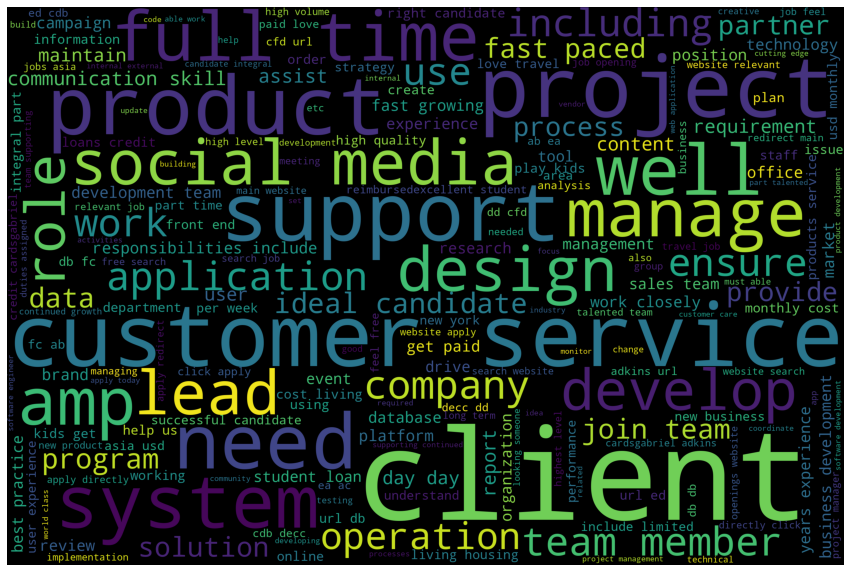

In [34]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The Description field is more tricky to compare than the company profile.

Although there is about as twice as many words as there was in the company profile, words with higher frequency are similar in both cases: team, business, experience, work, customer, etc.

### 2.3.3 Requirements

In [35]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [36]:
len(tokens_cp)

955963

In [37]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [38]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 2406
count of words: 43


#### 2.3.3.1 Requirements of Fraudulent Posts

In [39]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [40]:
len(tokens_cp)

36706

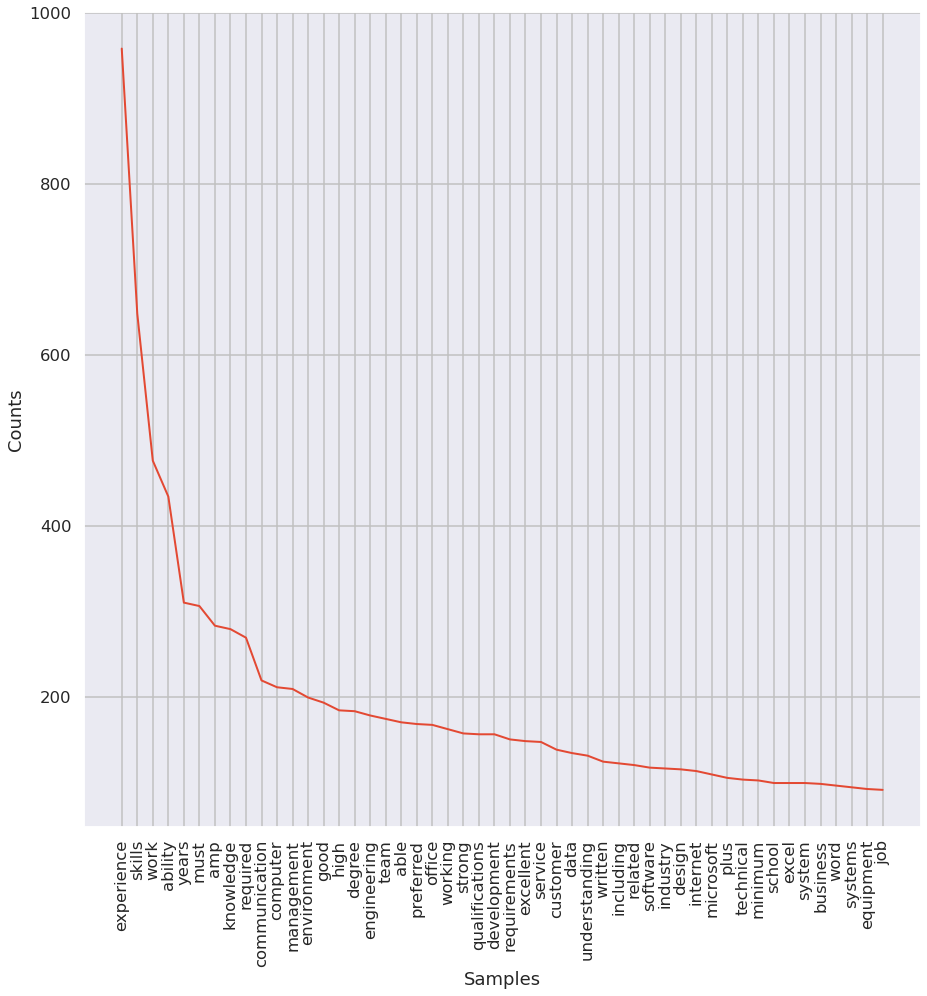

In [41]:
FreqDist(tokens_cp).plot(50)
plt.show()

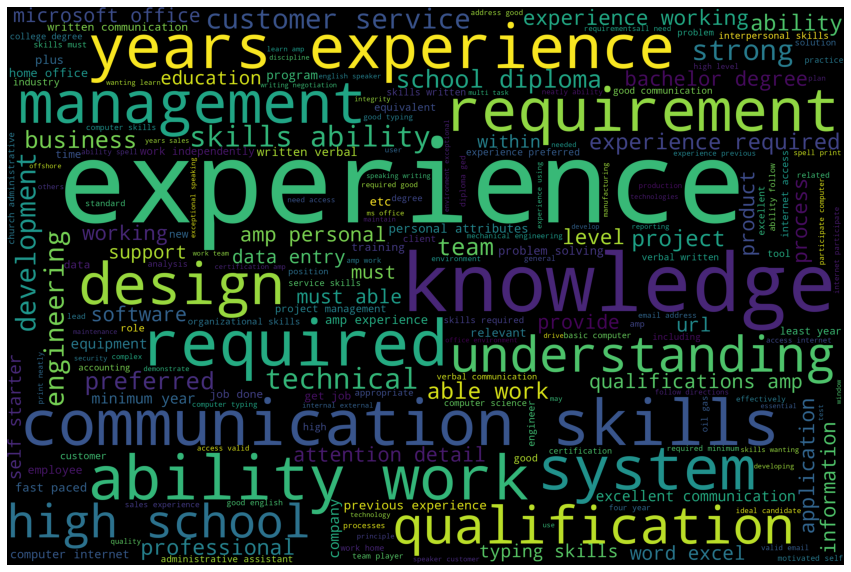

In [42]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.3.2 Description of Requirements Posts

In [43]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [44]:
len(tokens_cp)

946331

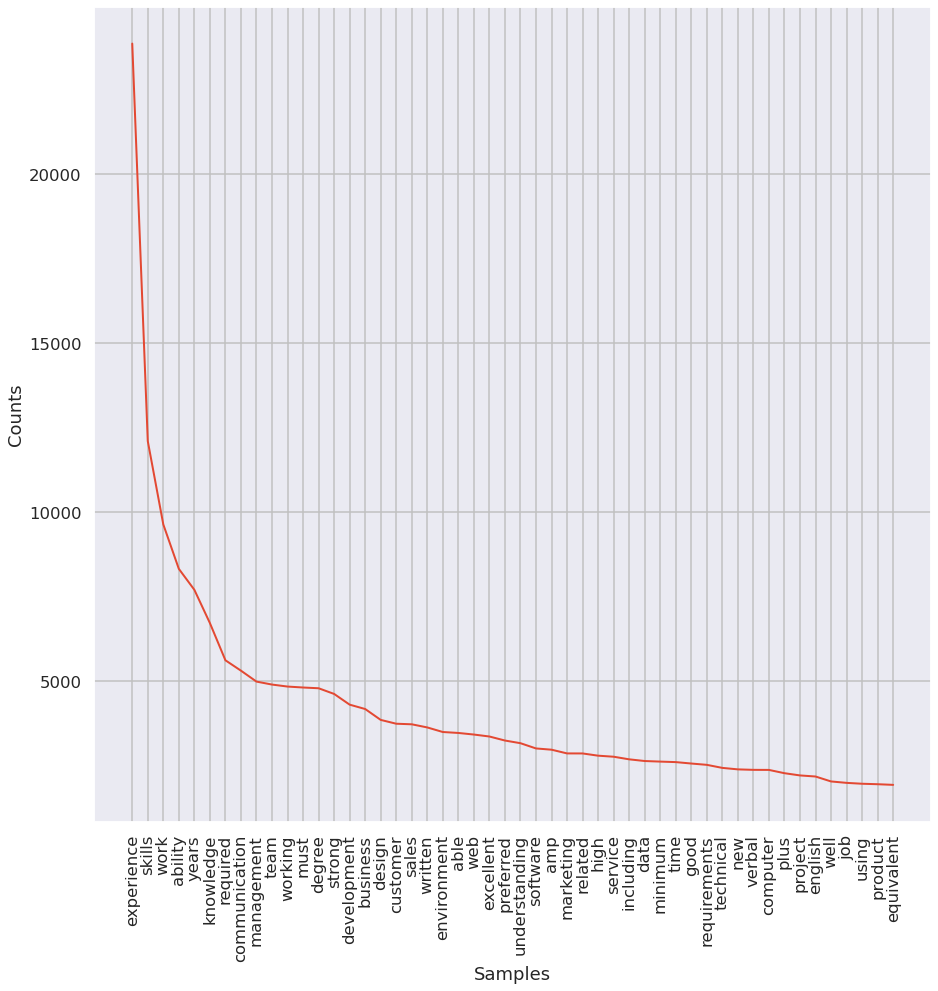

In [45]:
FreqDist(tokens_cp).plot(50)
plt.show()

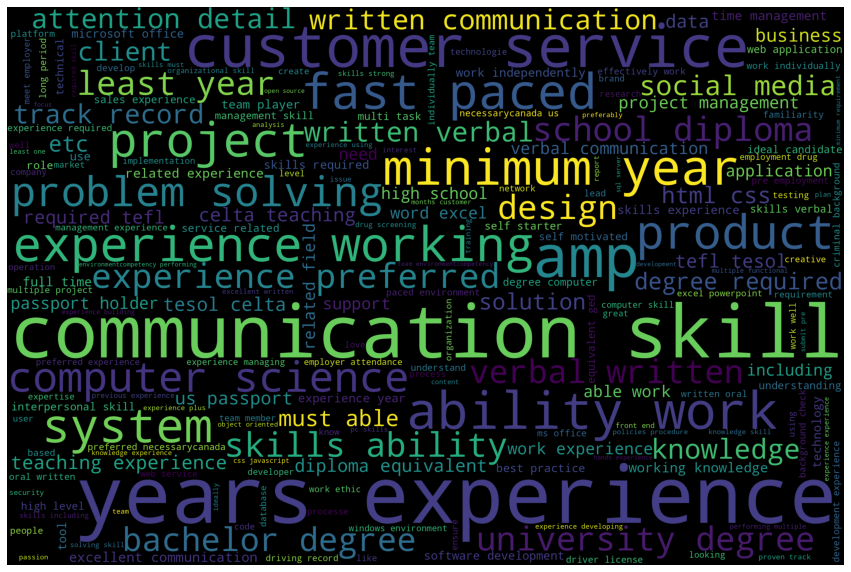

In [46]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As with the description field, the requirements field is not the best way to differenciate fraudulent posts from genuines ones. The most frequent words are the same. however the fraudulent posts seem to be more forceful than the legitimate ones, with the use of words such as: must, required, able, etc.

### 2.3.4 Benefits

In [47]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [48]:
len(tokens_cp)

330800

In [49]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [50]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 1988
count of words: 20


#### 2.3.4.1 Requirements of Fraudulent Posts

In [51]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [52]:
len(tokens_cp)

17033

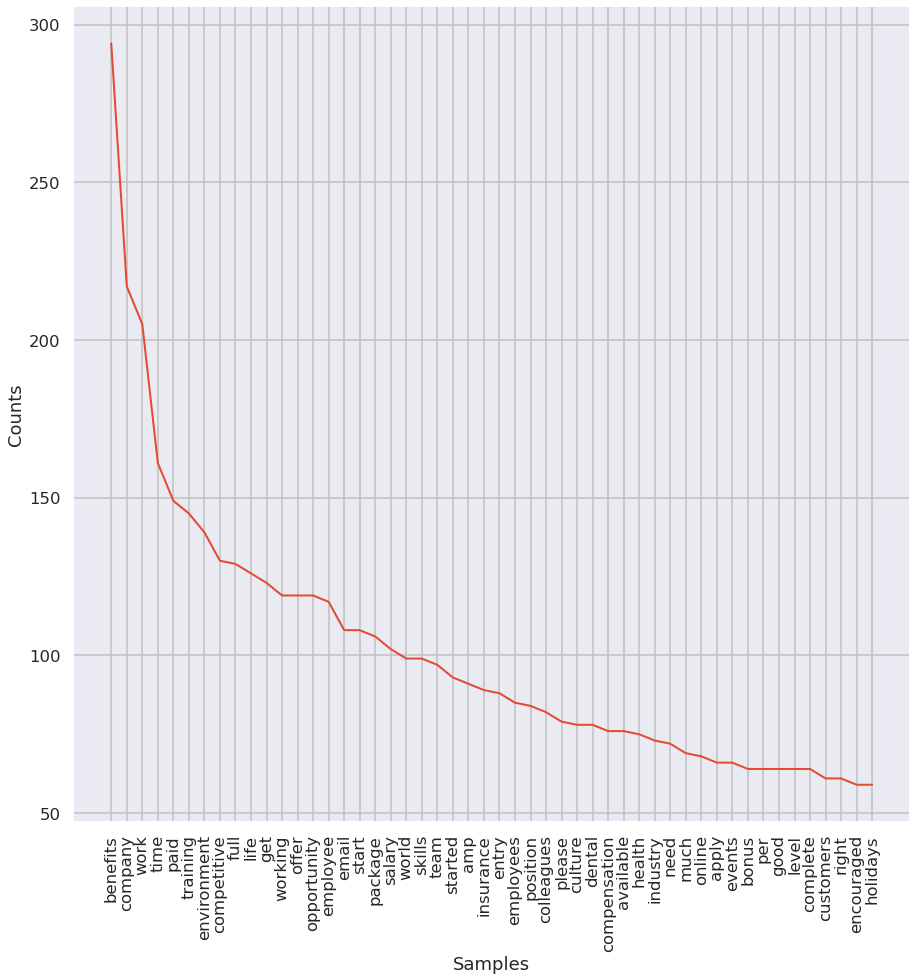

In [53]:
FreqDist(tokens_cp).plot(50)
plt.show()

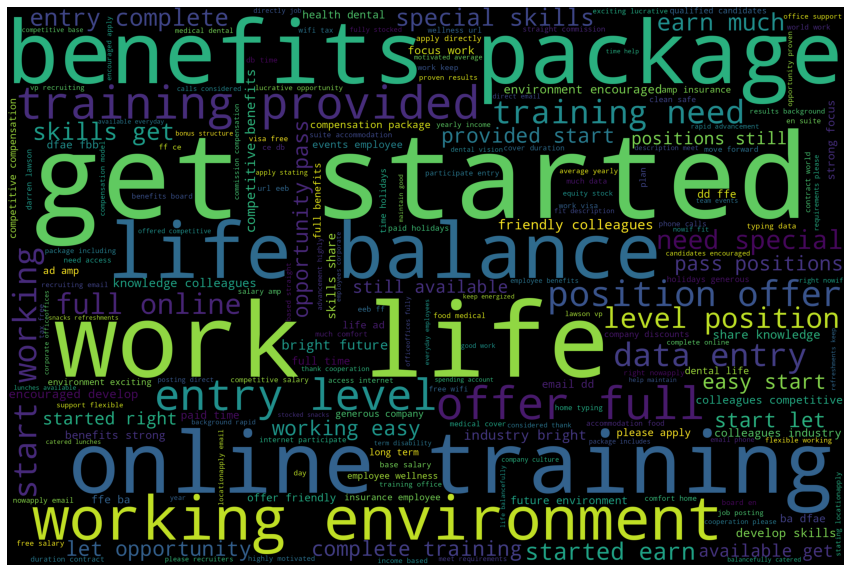

In [54]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.4.2 Description of Requirements Posts

In [55]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [56]:
len(tokens_cp)

338418

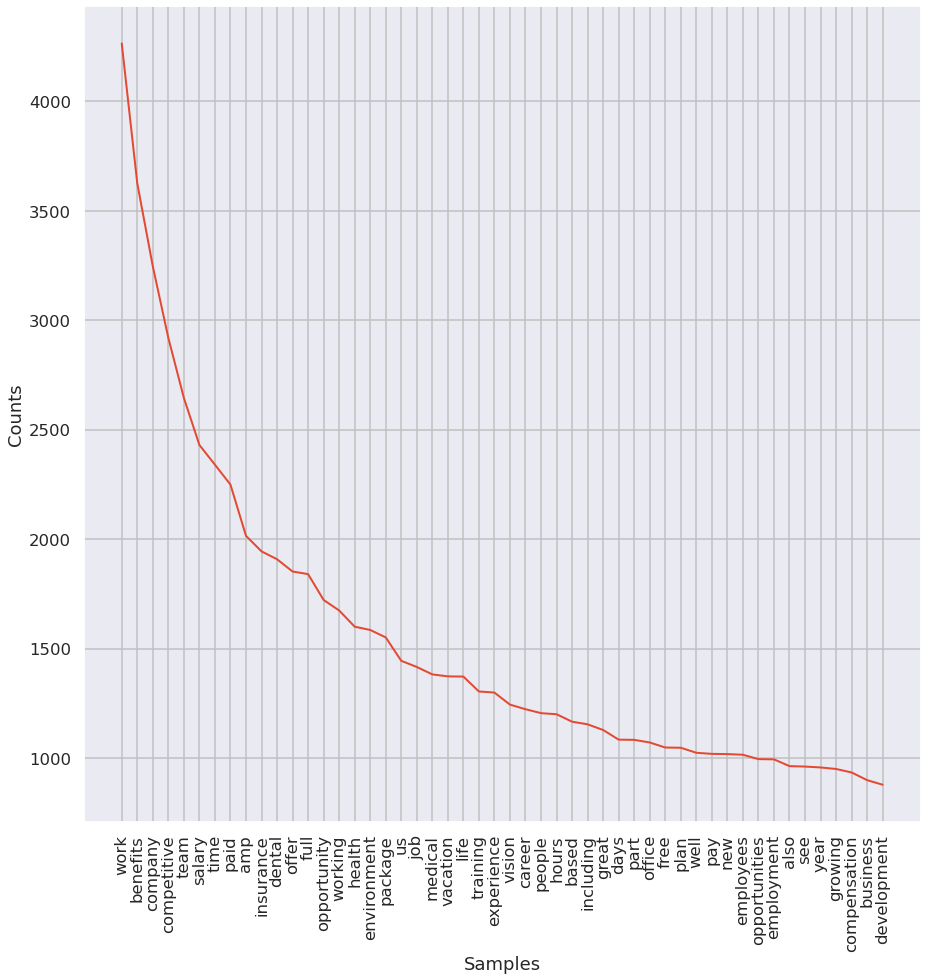

In [57]:
FreqDist(tokens_cp).plot(50)
plt.show()

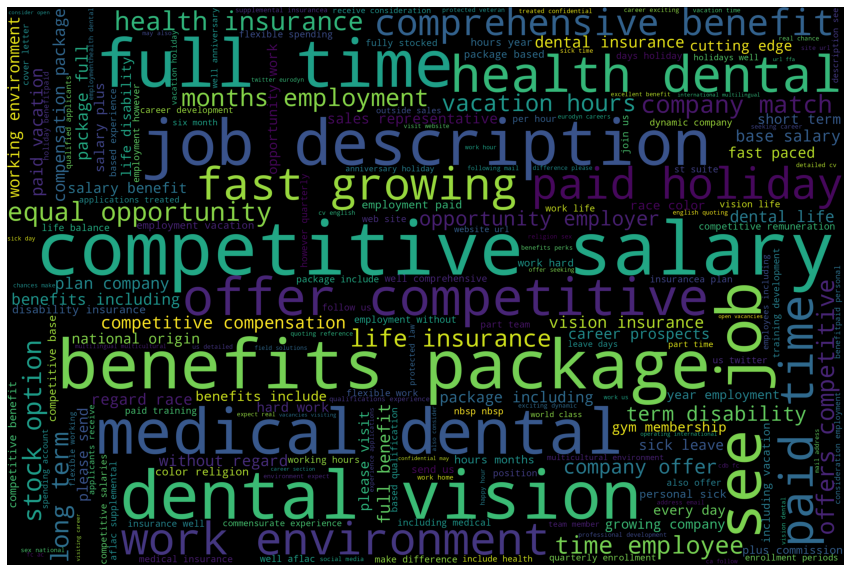

In [58]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The benefits field is a little more explicit when it comes to fraudulent posts. The scammers seem to be less keen on talking about medical and dental insurances, vacation days, etc. They are selling a dream, after all. It is harder to be specific in such conditions.

# 3. Categorical information

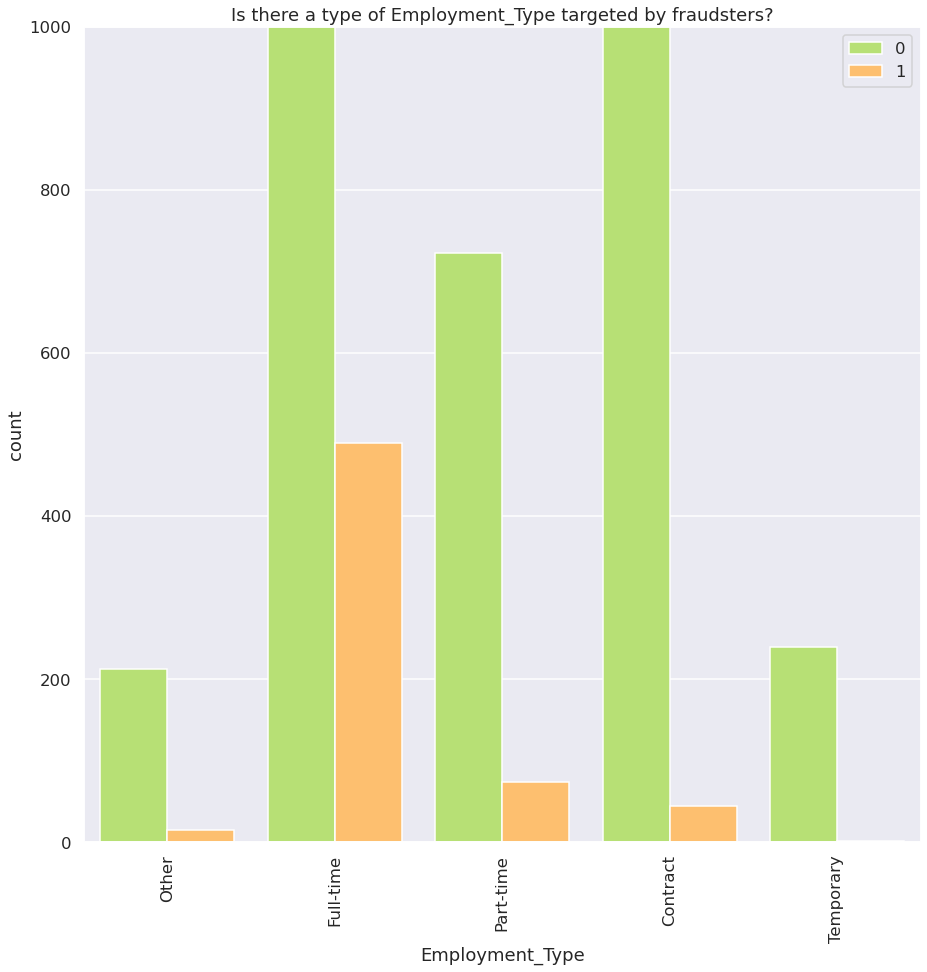

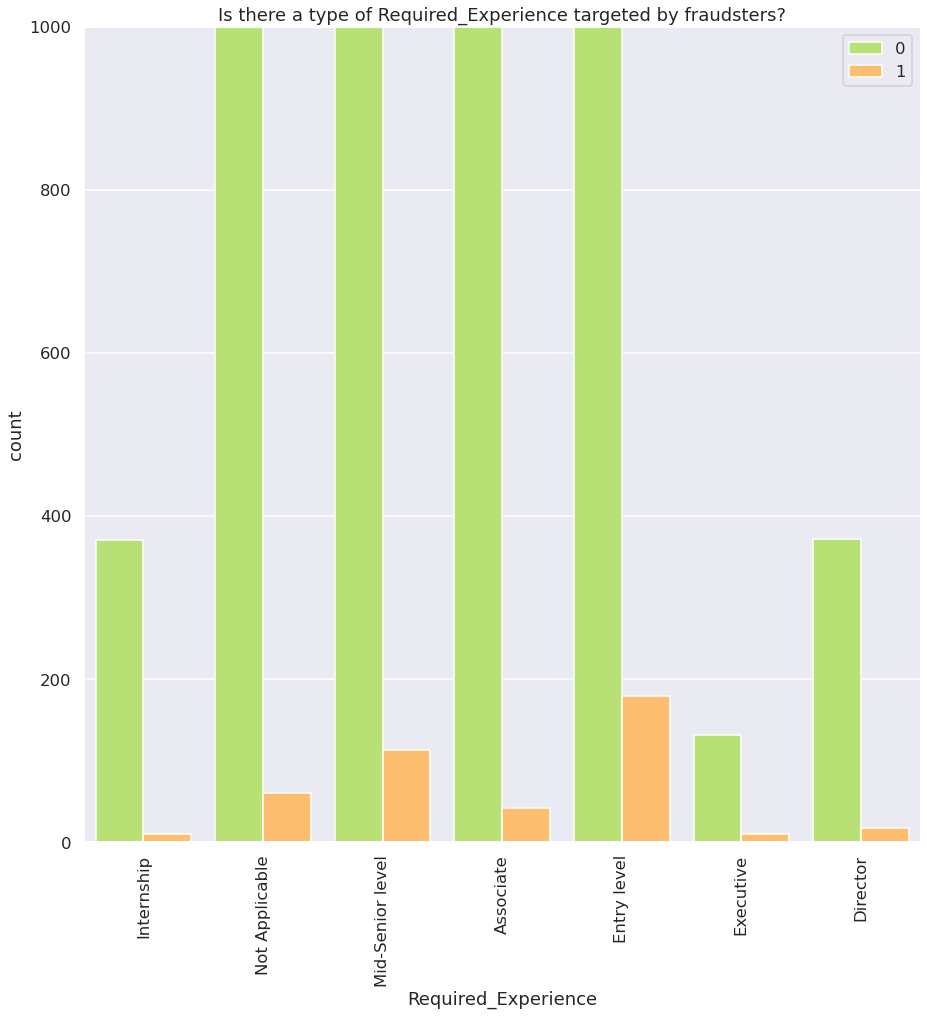

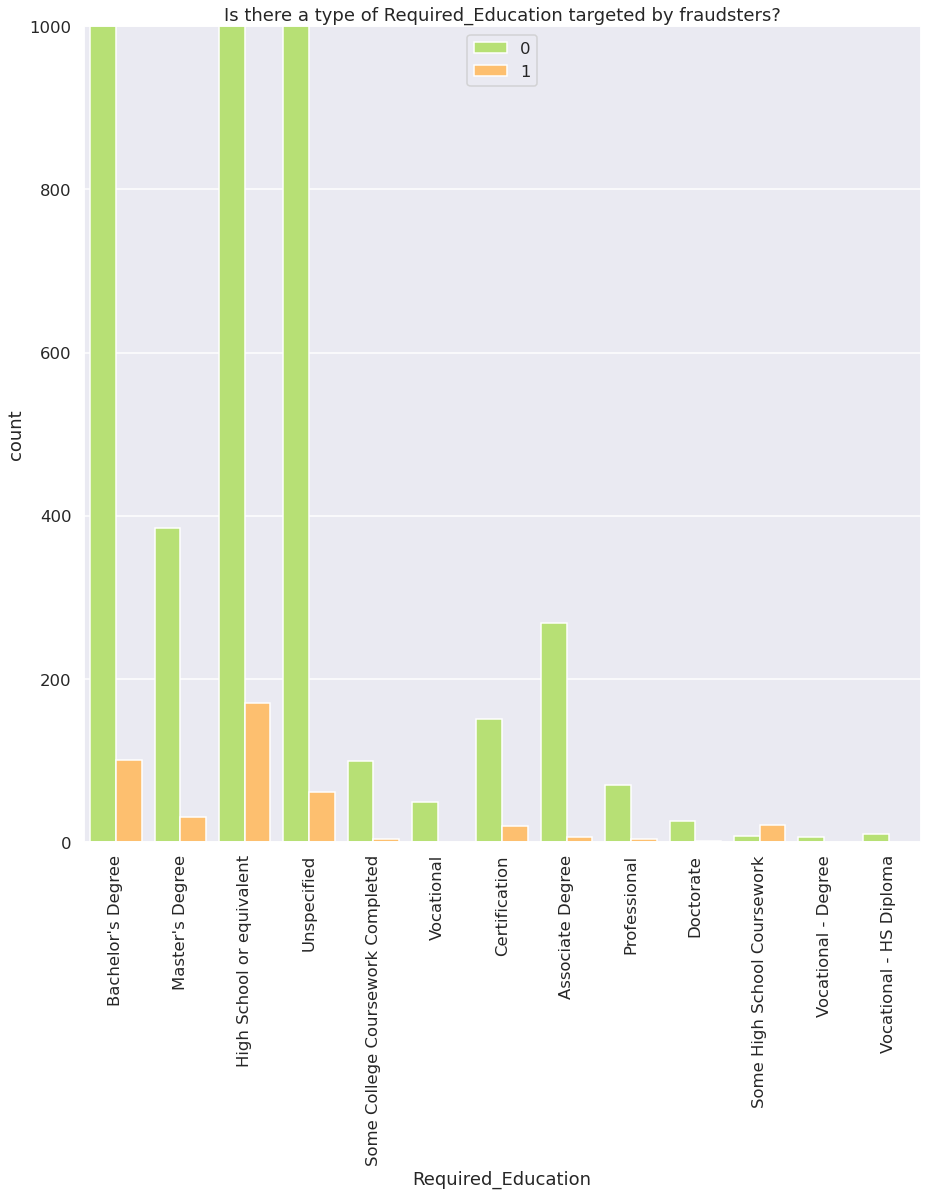

In [59]:
plots.Plots.count_plot(df,11,14)

# 4. Extracting extra information
Some job offers have a phone, email and/or external URL information:

In [60]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(HasEMAIL=0, HasPHONE=0, HasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['HasURL'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#PHONE_')!=-1:
            df['HasPHONE'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#EMAIL_')!=-1:
            df['HasEMAIL'][i] = 1

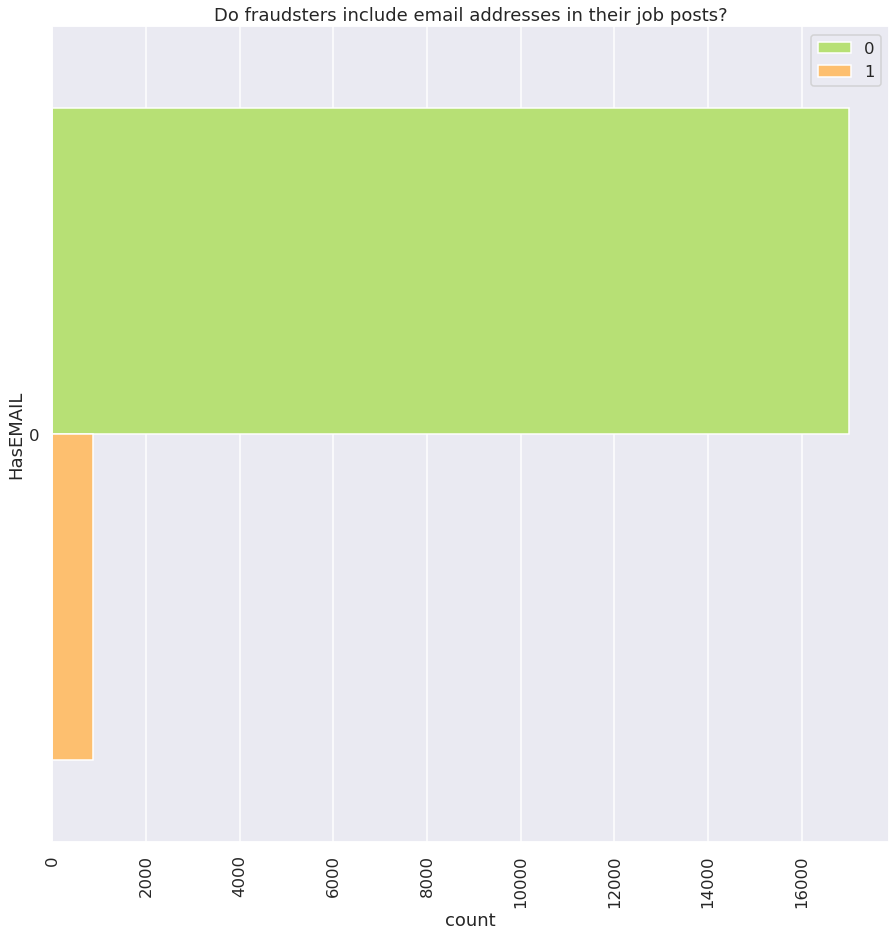

In [61]:
sns.countplot(y='HasEMAIL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

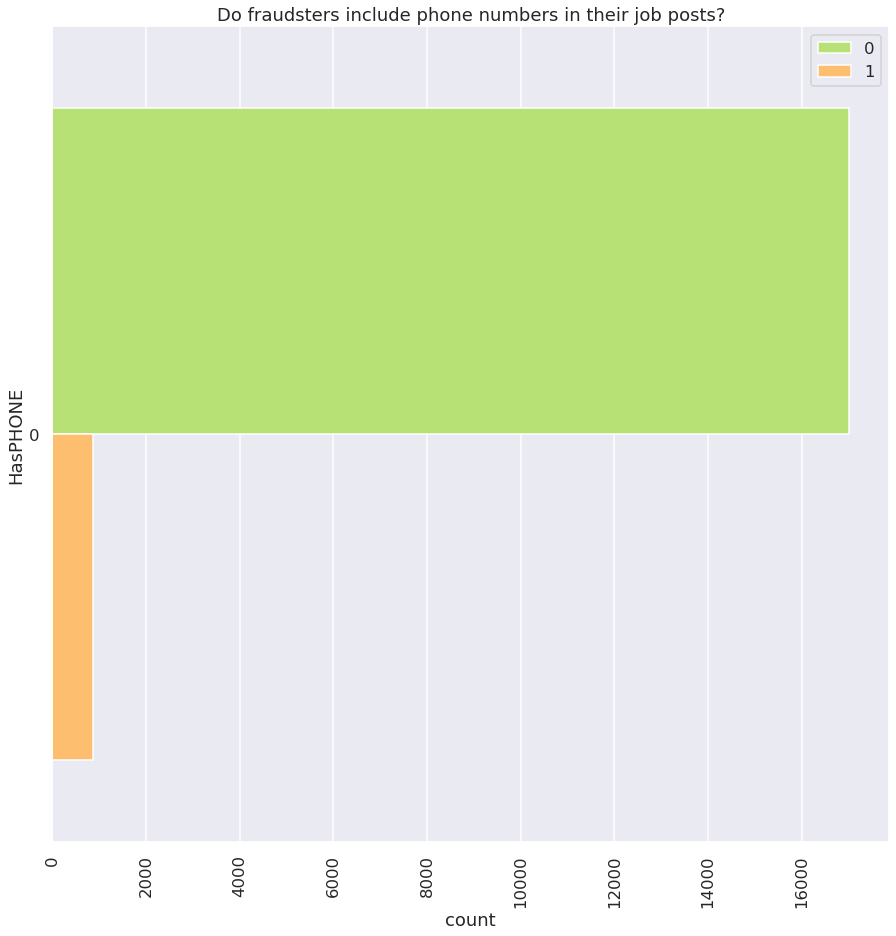

In [62]:
sns.countplot(y='HasPHONE', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

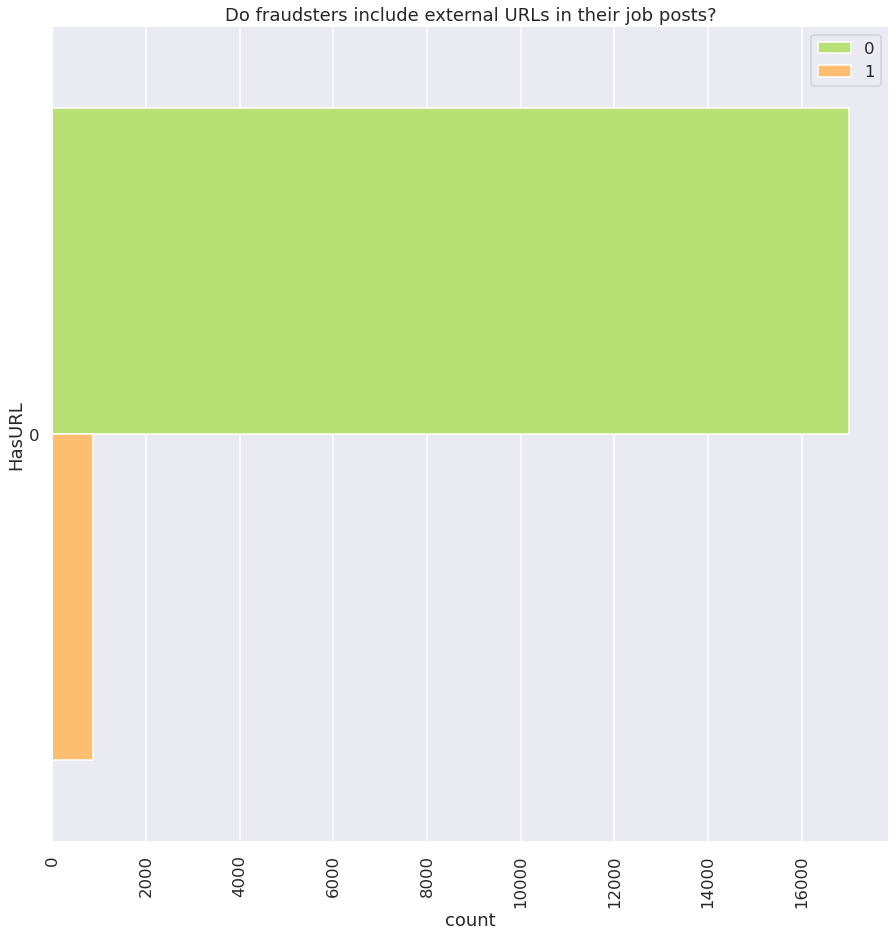

In [63]:
sns.countplot(y='HasURL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

# 5. Conclusion
Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:
* They tend to be lacking more information than the genuine job offers but, fraudsters will make an effort for information such as location, department, function and especially salary_range. 
* When information is provided, it will tend to be shorter, and the text will be more concise. This characteristic is especially true for the company profile and the job requirements fields.

In terms of content, fraudulent posts will:
* Target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational are not specifically targeted, some even not targeted at all (in this dataset at least).
* Mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but, proportionally less than any other type of post. Temporary contracts were not targeted at all (in this dataset at least).
* Target all types of experience but mainly entry-level positions. Once again, Associates are less exposed whilst Directors, Executive and Mid-Senior levels are a little less exposed.
* Tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but, as phone, emails and URLs are anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding of fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.